# Фадеев Артем, ИУ5-21М
## РК №1. Вариант 10.

In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import MissingIndicator, SimpleImputer, KNNImputer
import scipy.stats as stats
import matplotlib.ticker as ticker
from sklearn.feature_selection import VarianceThreshold

%matplotlib inline

In [125]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

In [126]:
def plot_hist_diff(old_ds, new_ds, cols):
    """
    Разница между распределениями до и после устранения пропусков
    """
    for c in cols:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(111)
        ax.title.set_text('Поле - ' + str(c))
        for xlabel_i in ax.get_xticklabels():
            xlabel_i.set_visible(False)
        #  Устанавливаем интервал основных делений:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
        #  Устанавливаем интервал вспомогательных делений:
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
        #  Тоже самое проделываем с делениями на оси "y":
        ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))
        old_ds[c].hist(bins=50, ax=ax, density=True, color='blue')
        new_ds[c].hist(bins=50, ax=ax, color='orange', density=True)
        plt.show()

In [127]:
data = pd.read_csv('./vgsales.csv', sep=',', encoding="utf-8")
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [128]:
data.isnull().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [129]:
data = data.drop(data[data["Year"].isnull()].index) # удаление кортежей с пустым полем Year

# Задача №10.
## Для набора данных проведите устранение пропусков для одного (произвольного) категориального признака с использованием метода заполнения наиболее распространенным значением.

In [130]:
data.isnull().sum()

Rank             0
Name             0
Platform         0
Year             0
Genre            0
Publisher       36
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
Global_Sales     0
dtype: int64

Получили немного кортежей с пустым категориальным значением Year

In [131]:
data_cat_cols = ['Publisher']
data_cat_new = data[data_cat_cols].copy()
Publisher_cat_new_temp, _, _ = impute_column(data_cat_new, 'Publisher', 'most_frequent')
data_cat_new['Publisher'] = Publisher_cat_new_temp

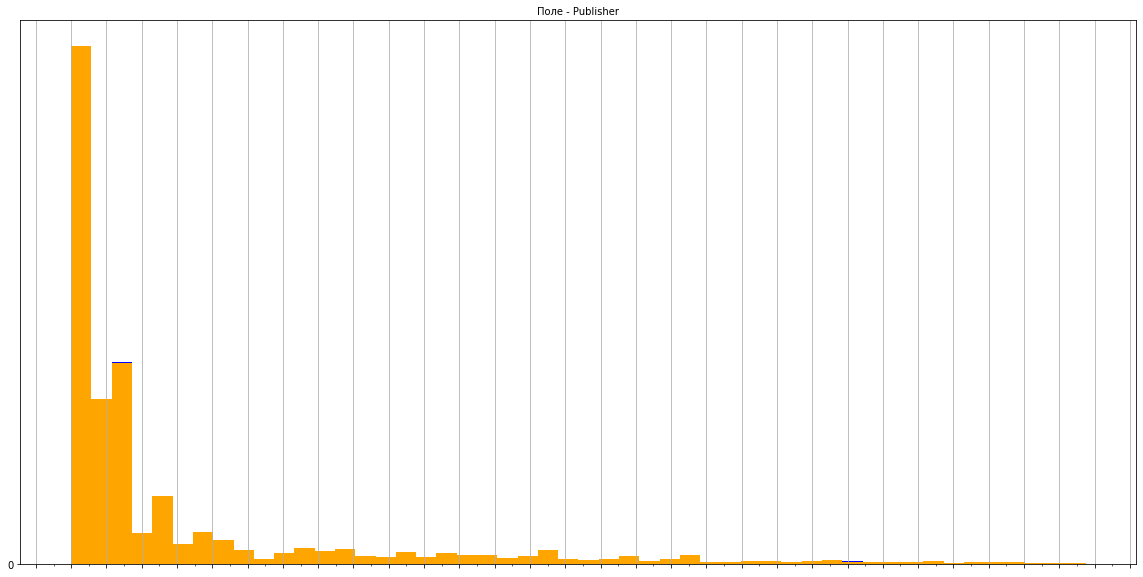

In [132]:
plot_hist_diff(data, data_cat_new, data_cat_cols)

Как видим, набор данных располагает слишком большим набором данных, чтобы добавление 36-ти строкам какое-либо значение столбца издательство на что-то повлияло: очень тоненькие полосочки на 3-й колонке и низкой колонке, располагающейся на 9-м справа делении осей Х.

In [133]:
data['Publisher'] = data_cat_new['Publisher']
data.isnull().sum() # Пропуски удалили

Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

# Задача №30.
## Для набора данных проведите удаление повторяющихся признаков.

Использую функцию, которая просмотрит каждую колонку датасета и попробует найти дублирующийся колонки

In [134]:
def get_duplicates(data):
    """
    Поиск дубликатов в колонках
    """
    pairs = {}
    dups = []
    # Перебор всех колонок (внешний)
    for i in range(data.shape[1]):
        # текущая колонка
        feat_outer = data.columns[i]
        # если текущая колонка не является дублем
        if feat_outer not in dups:
            # создаем запись в словаре, колонка является ключом
            pairs[feat_outer] = []
            # Перебор оставшихся колонок (внутренний)
            for feat_inner in data.columns[i + 1:]:
                # Если колонки идентичны
                if data[feat_outer].equals(data[feat_inner]):
                    # добавление в словарь и список дубликатов
                    pairs[feat_outer].append(feat_inner)
                    dups.append(feat_inner)
    return pairs

In [135]:
get_duplicates(data) # Понятно - не нашли дубликатов

{'Rank': [],
 'Name': [],
 'Platform': [],
 'Year': [],
 'Genre': [],
 'Publisher': [],
 'NA_Sales': [],
 'EU_Sales': [],
 'JP_Sales': [],
 'Other_Sales': [],
 'Global_Sales': []}

Попробую найти плохие признаки с помощью дисперсии и методов класса VarianceThreshold

In [138]:
#кодирование категориальных признаков
agg_data = data.groupby("Name").Rank.count().sort_values(ascending=False).reset_index()
agg_data.columns = ["name", "Name_Freq"]
data = pd.merge(data, agg_data, left_on="Name", right_on="name").drop(columns="name")

agg_data = data.groupby("Platform").Rank.count().sort_values(ascending=False).reset_index()
agg_data.columns = ["platform", "Platform_Freq"]
data = pd.merge(data, agg_data, left_on="Platform", right_on="platform").drop(columns="platform")

agg_data = data.groupby("Genre").Rank.count().sort_values(ascending=False).reset_index()
agg_data.columns = ["genre", "Genre_Freq"]
data = pd.merge(data, agg_data, left_on="Genre", right_on="genre").drop(columns="genre")

agg_data = data.groupby("Publisher").Rank.count().sort_values(ascending=False).reset_index()
agg_data.columns = ["publisher", "Publisher_Freq"]
data = pd.merge(data, agg_data, left_on="Publisher", right_on="publisher").drop(columns="publisher")

data = data.sort_values(by=["Rank"])
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Name_Freq,Platform_Freq,Genre_Freq,Publisher_Freq
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,1,1290,2304,696
203,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,2,98,876,696
55,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,1,1290,1226,696
1,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,1,1290,2304,696
532,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,1,97,1471,696


In [144]:
cols = ['Rank','Year','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Name_Freq','Platform_Freq','Genre_Freq','Publisher_Freq']
data_for_VT = data[cols]
selector = VarianceThreshold(threshold=0.15)
selector.fit(data_for_VT)
# Значения дисперсий для каждого признака
for i in range(len(cols)):
    print(cols[i], '\t', selector.variances_[i])

Rank 	 22968276.744677715
Year 	 33.97493980298204
NA_Sales 	 0.674970182131901
EU_Sales 	 0.25882668252020824
JP_Sales 	 0.09706180755441642
Other_Sales 	 0.03605426706900961
Name_Freq 	 2.492376571190176
Platform_Freq 	 400090.5433198231
Genre_Freq 	 778216.8057600536
Publisher_Freq 	 187506.215105879


Видим маленькую дисперсию по колонкам NA_Sales и EU_Sales, и крошечную по JP_Sales и Other_Sales

# Дополнительные требования по группам.
## Для пары произвольных колонок данных построить график "Диаграмма рассеяния".

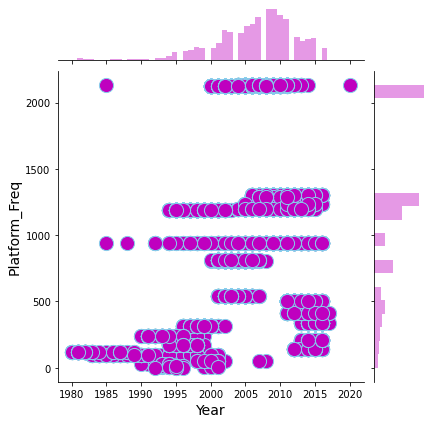

In [152]:
sns.jointplot(x=data["Year"], y=data["Platform_Freq"], kind='scatter', s=200, color='m', edgecolor="skyblue", linewidth=1)